In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
import os

In [2]:
IMG_SIZE = (100, 100)  # Size of images to be passed into the model
IMG_HEIGHT, IMG_WIDTH = 100, 100
# ---- For reproducibility ----- #
SEED = 123
BATCH_SIZE = 128

In [3]:
train_path = 'C:/Users/Deju/Downloads/archive/fruits-360_dataset/fruits-360/Training'
test_path = 'C:/Users/Deju/Downloads/archive/fruits-360_dataset/fruits-360/Test'

# ----- Create a train dataset object (tf.data.Dataset)----- #
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_path,
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
# ----- Create a test dataset object (tf.data.Dataset)----- #
test_set = tf.keras.utils.image_dataset_from_directory(
  shuffle=False, 
  directory=test_path, 
  label_mode="categorical",
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 67688 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.


In [4]:
# ----- Function to create a convolutional block in the CNN ----- # 
def create_conv_block(x, n_filters):
    # Create a 2D convolutional layer
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu", 
                               kernel_regularizer='l2', kernel_initializer='glorot_uniform')(x) 
    x = tf.keras.layers.MaxPooling2D()(x) # Reduces the spatial dimensions of the feature maps
    return x

def create_dense_block(x, n_units, dropout_rate=0.5):
    x = tf.keras.layers.Dense(n_units, activation="relu", kernel_regularizer='l2', kernel_initializer='glorot_uniform')(x) 
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def create_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape) 
    x = tf.keras.layers.Rescaling(1./255)(inputs) # Normalize pixel values of images from input

    # ---- Create convolutional blocks ----- #
    conv1 = create_conv_block(x, 64)
    conv2 = create_conv_block(conv1, 128)
    conv3 = create_conv_block(conv2, 256)
    conv4 = create_conv_block(conv3, 512)
    # ----- Flatten the output of the final convolutional block ----- #
    flat = tf.keras.layers.GlobalAveragePooling2D()(conv4)
    # ----- Classify using dense blocks ----- #
    dense1 = create_dense_block(flat, 256)
    dense2 = create_dense_block(dense1, 25)
    outputs = tf.keras.layers.Dense(131, activation="softmax")(dense2) # For multi-class classification (softmax)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# ----- Function to create sequential model type ----- #
def create_sequential_cnn(input_shape):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.InputLayer(input_shape=input_shape),
        
        # Convolutional blocks
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        # Global Average Pooling layer
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # Dense blocks
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(25, activation="relu", kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.2),
        
        # Output layer
        tf.keras.layers.Dense(131, activation="softmax")
    ])
    
    return model

In [5]:
# cnn = create_cnn(
#     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
# )
# cnn.summary()  # Display the summary of the model's architecture
cnn = create_sequential_cnn((IMG_HEIGHT, IMG_WIDTH, 3))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 256)      0

In [6]:
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  # Categorical cross-entropy loss function
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), # Stop after 5 epochs if val loss doesn't improve
    tf.keras.callbacks.ModelCheckpoint('./models/best_cnn.h5', monitor='val_accuracy', save_best_only=True)  # Saves best model
]

epochs = 10  # Number of iterations (epochs) 

In [7]:
# ----- Initiaite model training ----- #
cnn.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
529/529 [==============================] - 1630s 3s/step - loss: 6.0603 - accuracy: 0.0142 - val_loss: 5.3119 - val_accuracy: 0.0145
Epoch 2/10
529/529 [==============================] - 1506s 3s/step - loss: 4.0591 - accuracy: 0.1222 - val_loss: 1.4983 - val_accuracy: 0.6487
Epoch 3/10
529/529 [==============================] - 1414s 3s/step - loss: 1.5089 - accuracy: 0.5891 - val_loss: 0.6689 - val_accuracy: 0.8666
Epoch 4/10
529/529 [==============================] - 1266s 2s/step - loss: 0.9070 - accuracy: 0.7601 - val_loss: 0.4259 - val_accuracy: 0.9263
Epoch 5/10
529/529 [==============================] - 1266s 2s/step - loss: 0.6685 - accuracy: 0.8334 - val_loss: 0.3675 - val_accuracy: 0.9428
Epoch 6/10
529/529 [==============================] - 1324s 3s/step - loss: 0.5328 - accuracy: 0.8756 - val_loss: 0.3308 - val_accuracy: 0.9634
Epoch 7/10
529/529 [==============================] - 1317s 2s/step - loss: 0.4511 - accuracy: 0.8995 - val_loss: 0.2625 - val_accuracy:

In [15]:
# ----- Function to plot training curves (loss and accuracy) ----- #
def plot_training_curves(model, model_name):

    history = model.history.history

    plt.figure(figsize=(15, 5))  # Size of the complete figure

    plt.subplot(1, 2, 1)  # Select first subplot
    plt.plot(history['loss'], label='Training loss') 
    plt.plot(history['val_loss'], label='Validation loss')
    plt.legend()  # Show the names for the color of lines in plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)  # Select second subplot
    plt.plot(history['accuracy'], label='Training accuracy')
    plt.plot(history['val_accuracy'], label='Validation accuracy')
    plt.legend()  # Show the names for the color of lines in plot
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
 
    plt.suptitle(f'{model_name} Training performance')  # Centered title for the figure
    plt.show()

# ----- Function for prediction using the model ----- #
def predict(dataset, model):
    pred_vals = np.argmax(model.predict(dataset), axis=-1)  # Values for predicted class/category by the model
    true_vals = np.concatenate([label for img, label in dataset], axis=0)
    true_vals = np.argmax(true_vals, axis=-1)  # Values for the actual class (category)
    # ----- Returns the predicted values and the true values ----- #
    return pred_vals, true_vals

# ----- Function to show the evaluation of the model ----- #
def show_performance_evaluation(dataset, model):  

    pred_vals, true_vals = predict(dataset, model)  # predict() function's return

    # plt.figure(figsize=(7, 7))  # Size of the figure to plot
    # class_names = dataset.class_names  
    # ax = sns.heatmap(confusion_matrix(true_vals, pred_vals), annot=True, xticklabels=class_names, yticklabels=class_names)  # Seaborn heatmap
    # ax.set_title(f"Confusion Matrix: ({len(pred_vals)} samples)")  # Confusion matrix title 
    # plt.show()
    class_names = [folder_name for folder_name in os.listdir(train_path)]
    print("\n\nClassification Report:\n")
    print(classification_report(true_vals, pred_vals, labels=[i for i in range(0, 132)], target_names=class_names))

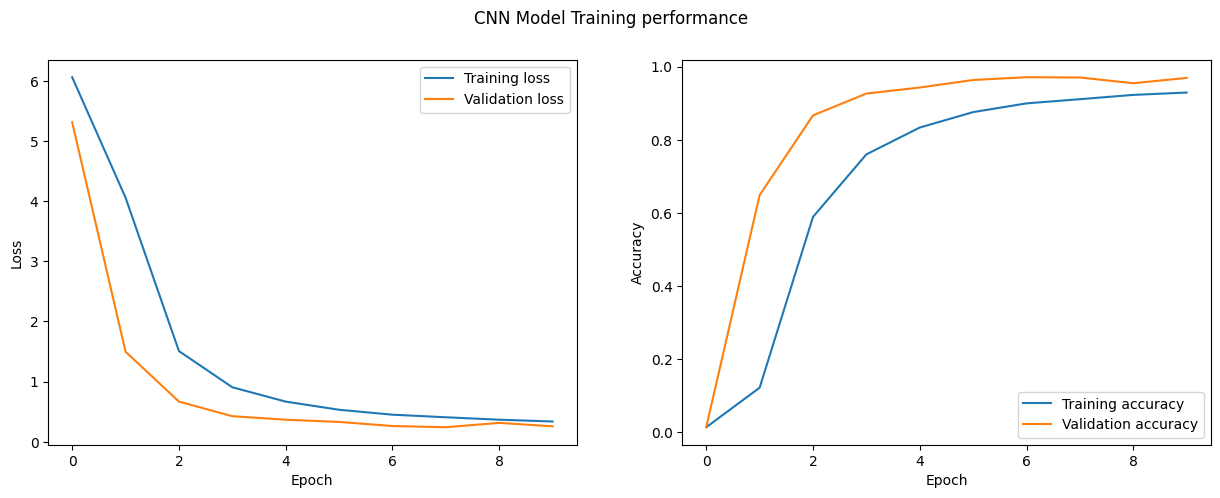

In [9]:
# ----- Show training (loss and accuracy) curves during the model training process ----- #
plot_training_curves(cnn, 'CNN Model')

In [16]:
final_model = tf.keras.models.load_model('./models/best_cnn.h5')  #Load the model from the saved directory
show_performance_evaluation(dataset=test_set, model=final_model)

178/178 [==============================] - 123s 689ms/step


Classification Report:

                     precision    recall  f1-score   support

     Apple Braeburn       0.99      0.92      0.96       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       0.79      1.00      0.88       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.69      1.00      0.81       161
 Apple Granny Smith       1.00      0.55      0.71       164
    Apple Pink Lady       0.93      1.00      0.96       152
        Apple Red 1       0.82      1.00      0.90       164
        Apple Red 2       1.00      1.00      1.00       164
        Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious       0.95      1.00      0.97       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.89      1.00      0.94       164

c:\Users\Deju\anaconda3\envs\devspace\lib\site-packages\sklearn\metrics\_classification.py:2620: UserWarning: labels size, 132, does not match size of target_names, 131
  warnings.warn(
c:\Users\Deju\anaconda3\envs\devspace\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deju\anaconda3\envs\devspace\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deju\anaconda3\envs\devspace\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being se